In [1]:
%matplotlib inline
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pink_utils as pu
import pandas as pd
import astropy.units as u
from astropy.table import Table
from tqdm import tqdm
from astropy.coordinates import SkyCoord, search_around_sky, concatenate
from pink_utils import Annotation
from scipy.stats import percentileofscore

In [2]:
# df = pd.read_csv('./Predicting_radio_ccomplete.csv')
df = pd.read_csv('./Predicting_radio_complete_whost.csv')
first = Table.read('../../first_14dec17.fits.gz')

In [3]:
df.columns

Index(['Unnamed: 0', 'DEC', 'FINT', 'FITTED_MAJOR', 'FITTED_MINOR',
       'FITTED_POSANG', 'FLDNAME', 'FPEAK', 'MAJOR', 'MINOR', 'MJD', 'MJDRMS',
       'MJDSTART', 'MJDSTOP', 'NSDSS', 'NTMASS', 'POSANG', 'RA', 'RMS',
       'SDSS_CLASS', 'SDSS_MAG', 'SDSS_SEP', 'SIDEPROB', 'TMASS_MAG',
       'TMASS_SEP', 'Unnamed: 0.1', 'Unnamed: 0.1.1', 'Unnamed: 0.1.1.1',
       'YEAR', 'bmu_clicks', 'bmu_ed', 'bmu_index', 'bmu_pos', 'bmu_score',
       'click_count', 'fake_dec', 'fake_host_dec', 'fake_host_ra', 'fake_ra',
       'fake_sep', 'filename', 'first_dec', 'first_index', 'first_ra',
       'host_dec', 'host_ra', 'index', 'pred_dec', 'pred_ra', 'pred_sep'],
      dtype='object')

In [4]:
plt.close('all')

class PredictionSet():
    """Class to accept predicted positions to cross match with
    """
    def __init__(self, pos: list, uid: int, row: pd.Series, index: int):
        """Create new instance
        
        pos ({list}) -- List (or list like) of SkyCoord positions
        uid ({int}) -- Unique numeric (or hashable) identifier
        row ({pd.Series}) -- Row of the centred source clicks are generated for
        index ({int}) -- Index of the `row` taken from 
        """
        self.pos = pos
        self.uid = uid
        if isinstance(pos, list):
            self.cat = SkyCoord(ra=[i.ra for i in pos], dec=[i.dec for i in pos])
        else:
            self.cat = pos
        self.mean_pos = SkyCoord(ra=self.cat.ra.mean(), dec=self.cat.dec.mean())
        self.link_id = None
        self.row = row
        self.first_index = index

        

ms = ['o','*','>']
c  = ['red', 'blue', 'black']
cmap = 'Greys'
predictions = []

print(len(df['first_index'].unique()))

for first_index, sub_df in tqdm(df.groupby('first_index')):
    pos = SkyCoord(ra=sub_df['pred_ra'].values*u.deg, dec=sub_df['pred_dec'].values*u.deg)
    
    predict = PredictionSet(pos, len(predictions) + 1, sub_df.copy(), first_index)
    predictions.append(predict)
    


178859


100%|██████████| 178859/178859 [04:57<00:00, 601.10it/s]


In [5]:
MASTER_ID = 0
RADIUS = 15*u.arcsecond
MAJOR_RADIUS = 5 * u.arcminute

mean_positions = SkyCoord(ra=[i.mean_pos.ra for i in predictions], 
                          dec=[i.mean_pos.dec for i in predictions])
mean_results = search_around_sky(mean_positions, mean_positions, seplimit=MAJOR_RADIUS)

print(mean_results[0].shape)
print(mean_results)

(276777,)
(array([     0,      1,      2, ..., 178858, 178858, 178858]), array([     0,      1,      2, ..., 178854, 178856, 178858]), <Angle [0.        , 0.        , 0.        , ..., 0.08144871, 0.05671275,
        0.        ] deg>, <Quantity [0.        , 0.        , 0.        , ..., 0.00142155, 0.00098982,
           0.        ]>)


In [6]:
len(predictions)

178859

/Users/gal16b/miniconda3/envs/pink_e3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


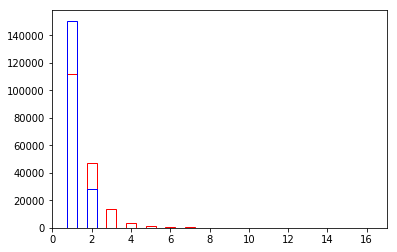

In [7]:
from collections import Counter

counts = Counter(mean_results[0])
grp_counts = Counter(counts.values())
list_counts = Counter([len(i.pos) for i in predictions])

fig, ax = plt.subplots(1,1)

ax.bar(grp_counts.keys(), grp_counts.values(), width=0.5, fill=False, edgecolor='red')
ax.bar(list_counts.keys(), list_counts.values(), width=0.5, fill=False, edgecolor='blue')


fig.show()

In [8]:
from collections import defaultdict

class Linker():
    idd = 0
    def __init__(self):
        self.lookup = {}
        self.table = defaultdict(list)
       
    def new_id(self):
        idd = self.idd
        self.idd += 1
        
        return idd
        
        
    def add_single_object(self, pred_1):
        idx_pred_1 = self.lookup[pred_1] if pred_1 in self.lookup.keys() else None
        if idx_pred_1 is None:
            idd = self.new_id()
            
            self.lookup[pred_1] = idd
            self.table[idd].append(pred_1)
            
            return
        else:
            # Nothing to do?
            return
        
        
    def add_predition(self, pred_1, pred_2):
        if pred_2 is None:
            self.add_single_object(pred_1)
            return
        
        idx_pred_1 = self.lookup[pred_1] if pred_1 in self.lookup.keys() else None
        idx_pred_2 = self.lookup[pred_2] if pred_2 in self.lookup.keys() else None
        
        if idx_pred_1 is None and idx_pred_2 is None:
            idd = self.new_id()
            self.table[idd].append(pred_1)
            self.table[idd].append(pred_2)
            self.lookup[pred_1] = idd
            self.lookup[pred_2] = idd    

            return
        
        elif idx_pred_1 is not None and idx_pred_2 is None:
            idd = self.lookup[pred_1]
            self.lookup[pred_2] = idd
            self.table[idd].append(pred_2)
            
            return
        
        elif idx_pred_2 is not None and idx_pred_1 is None:
            idd = self.lookup[pred_2]
            self.lookup[pred_1] = idd
            self.table[idd].append(pred_1)
            return
        
        elif idx_pred_1 is not None and idx_pred_2 is not None:
            idd_1 = self.lookup[pred_1]
            idd_2 = self.lookup[pred_2]
        
            if idd_1 == idd_2:
                # do nothing as they are already linked?
                return
            
            else:
                idd = self.new_id()
                
                list_1 = self.table[idd_1]
                list_2 = self.table[idd_2]
                                
                list_idd = list(set(list_1 + list_2))
                
                self.table[idd].extend(list_idd)
        
                for p in list_idd:
                    if self.lookup[p] in self.table.keys():
                        self.table.pop(self.lookup[p])
                    self.lookup[p] = idd

    def iterate_groups(self):
        for key, items in self.table.items():
            yield key, concatenate([i.pos for i in items]), [i.row for i in items]
            

links = Linker()

for pidx1, pidx2 in tqdm(zip(mean_results[0], mean_results[1])):
    if pidx1 == pidx2:
        ps1 = predictions[pidx1]
        links.add_predition(ps1, None)
    else:
        ps1 = predictions[pidx1]
        ps2 = predictions[pidx2]

        comp = search_around_sky(ps1.cat, ps2.cat, seplimit=RADIUS)
        if len(comp[0]) > 1:
            links.add_predition(ps1, ps2)

print('Done')

276777it [01:55, 2398.15it/s]

Done


In [9]:
links.table

defaultdict(list,
            {0: [<__main__.PredictionSet at 0x1a23d3cd30>],
             1: [<__main__.PredictionSet at 0x1a1d3d6898>],
             2: [<__main__.PredictionSet at 0x1a1d3d8400>],
             3: [<__main__.PredictionSet at 0x1a1d3d8f28>],
             4: [<__main__.PredictionSet at 0x1a1d3d9a90>],
             5: [<__main__.PredictionSet at 0x1a1d3dc5f8>],
             6: [<__main__.PredictionSet at 0x1a1d3e1160>],
             7: [<__main__.PredictionSet at 0x1a1d3e1c88>],
             8: [<__main__.PredictionSet at 0x1a1d3e37f0>],
             9: [<__main__.PredictionSet at 0x1a1d3e8358>,
             10: [<__main__.PredictionSet at 0x1a1d3ec9e8>],
             11: [<__main__.PredictionSet at 0x1a1d3ee550>],
             12: [<__main__.PredictionSet at 0x1a1d3f30b8>],
             13: [<__main__.PredictionSet at 0x1a1d3f3be0>],
             14: [<__main__.PredictionSet at 0x1a1d3fa748>],
             15: [<__main__.PredictionSet at 0x1a1d3fc2b0>],
             16: 

In [10]:
from collections import Counter

a = Counter([len(v) for k, v in links.table.items()])

In [11]:
a

Counter({1: 173016, 2: 2744, 3: 109, 4: 7})

In [12]:
777/50000 * 100

1.554

In [13]:
first_cata = SkyCoord(ra=first['RA'], dec=first['DEC'])

In [15]:
first['GroupID'] = 0.
first['MemberProb'] = 0.


def calc_P(sep, density=(90/(u.deg))**2.):
    """Calculate the chance coincidence a separation and density. 
    """
    
    return np.exp(-np.pi * density * (sep.to(u.deg))**2.)

def calc_member_likelihood(matches, pos, dfs):
    """Given the sample BMU score an dother properties, calculate the likelihood that
    each source is a genuine match for the group
    """
    dfs = pd.concat(dfs)

    likes = []
    for unique_idd in matches[0]:
        mask = matches[0] == unique_idd
        sep = matches[2][mask]
        scores = dfs.iloc[matches[0][mask]]['bmu_score']
        likes.append(np.mean( ((100.-scores)/100. + calc_P(sep))/2 ))
        
    return np.array(likes)
         
for idd, pos, dfs in tqdm(links.iterate_groups()):
    matches = search_around_sky(pos, first_cata, seplimit=5*u.arcsecond)
    like    = calc_member_likelihood(matches, pos, dfs)  
    
    first['GroupID'][matches[1]] = idd
    first['MemberProb'][matches[1]] = like

175876it [3:54:47, 12.48it/s] 


In [16]:
from download_images import _first, make_dir
import os
import aplpy as apl
from astropy.wcs import WCS
from astropy.io import fits
from astropy.wcs.utils import skycoord_to_pixel
from itertools import combinations

In [17]:
first.group_by('GroupID')

RA,DEC,SIDEPROB,FPEAK,FINT,RMS,MAJOR,MINOR,POSANG,FITTED_MAJOR,FITTED_MINOR,FITTED_POSANG,FLDNAME,NSDSS,SDSS_SEP,SDSS_MAG,SDSS_CLASS,NTMASS,TMASS_SEP,TMASS_MAG,YEAR,MJD,MJDRMS,MJDSTART,MJDSTOP,GroupID,MemberProb
deg,deg,,mJy,mJy,mJy,arcsec,arcsec,deg,arcsec,arcsec,deg,,,arcsec,,,,arcsec,,year,day,day,day,day,,
float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,bytes12,int16,float32,float32,bytes1,int16,float32,float32,float32,float64,float64,float64,float64,float64,float64
111.89286932282256,64.68327796842226,0.19721268,1.0,1.12,0.13937247,2.13,1.58,0.2,5.8,5.63,0.2,07300+64243J,-1,99.0,99.0,-,1,6.7602487,14.616,2002.6866,2452526.1387495776,0.002275884898136695,2452526.126331019,2452526.1411921303,0.0,0.5396293307848946
114.66376778607003,64.67118853359135,0.014053002,2.39,5.7292995,0.13908058,9.31,3.58,136.6,10.76,6.48,136.6,07360+64243J,-1,99.0,99.0,-,0,99.0,99.0,2002.6866,2452526.143550602,0.0012772732031929414,2452526.143344908,2452526.153344908,0.0,0.0
117.60007977063684,64.66700162763013,0.014053002,22.09,24.001633,0.1399179,1.96,1.13,6.8,5.74,5.52,6.8,07480+64243J,-1,99.0,99.0,-,0,99.0,99.0,2002.6866,2452526.1478428137,0.0016199358523287725,2452526.1475000004,2452526.1575231487,0.0,0.0
114.69009133513126,64.66392121231445,0.014053002,2.39,4.3332715,0.13961881,6.43,3.27,13.5,8.4,6.31,13.5,07360+64243J,-1,99.0,99.0,-,0,99.0,99.0,2002.6866,2452526.143344908,0.0,2452526.143344908,2452526.1453587967,0.0,0.0
114.88666417944421,64.65500781544758,0.082168914,1.41,1.2519828,0.13919109,2.63,0.0,37.5,6.01,4.3,37.5,07420+64243J,-1,99.0,99.0,-,0,99.0,99.0,2002.6866,2452526.1438054247,0.0021023171477542505,2452526.143344908,2452526.1554282415,0.0,0.0
117.63454490518873,64.64652472049842,0.016282696,1.36,1.065946,0.13712496,1.5,0.0,19.2,5.61,4.05,19.2,07480+64243J,-1,99.0,99.0,-,0,99.0,99.0,2002.6866,2452526.1478523905,0.0016413788073996135,2452526.1475000004,2452526.1575231487,0.0,0.0
109.99329126180447,64.64337600329105,0.014053002,2.94,3.1695168,0.1478423,3.08,0.0,147.8,6.22,5.05,147.8,07180+64243J,-1,99.0,99.0,-,0,99.0,99.0,2002.6866,2452526.1354180407,0.004716363120972734,2452526.1221527783,2452526.139108797,0.0,0.0
105.43140108496378,64.64258370134733,0.014053002,1.69,1.572639,0.14919707,1.45,0.0,133.8,5.59,4.85,133.8,07000+64243J,1,0.6550031,21.709148,g,0,99.0,99.0,2002.6866,2452526.1284578433,0.005474463458914033,2452526.115902778,2452526.132858797,0.0,0.0


In [18]:
marker = ['o','*','^', '>']
color = ['red','green','purple','orange']
out_dir = 'first_down'
make_dir(out_dir)

plt.close('all')

for i in range(300):   
    if not i in links.table.keys():
        continue
        
    try:  
        pos = links.table[i][0].mean_pos
        name = links.table[i][0].first_index
        preds = links.table[i]
        
    except IndexError:
        print(i)
        print(links.table[i])
        
    match = pos.separation(first_cata) < 1*u.arcminute
    
    
    if not os.path.exists(f"{out_dir}/{name}.fits"):
        _first(pos, out_dir, fn=f"{name}.fits", cutout_size=3.5)
        
    f = fits.open(f"{out_dir}/{name}.fits")
    w = WCS(f[0].header).celestial

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111,projection=w)

    ax.imshow(f[0].data, cmap='Greys')

    for count, sub_first in enumerate(first[match].group_by('GroupID').groups):        
        sub_first_cata = SkyCoord(ra=sub_first['RA'], dec=sub_first['DEC'])
        pix = skycoord_to_pixel(sub_first_cata, w, 0)
        ax.scatter(pix[0], pix[1], facecolors='none', edgecolors=color[count], s=250, linewidth=4,
                  label=f'GID {count} FIRST Catalogue Sources')
        
        
#     pix = skycoord_to_pixel(first_cata[match], w, 0)
#     ax.scatter(pix[0], pix[1], facecolors='none', edgecolors='blue', s=250, linewidth=4,
#               label='FIRST Catalogue Sources')
    ax.set(title=f"{len(preds)} Prediction Set")

    for c, p in enumerate(preds):
        pix = skycoord_to_pixel(p.cat, w, 1)
        ax.plot(pix[0], pix[1], marker=marker[c], color=color[c], label=f"{c+1} Prediction set")
        ax.plot(pix[0], pix[1], color=color[c])

    ax.legend(loc='best')
    fig.savefig(f"matched_predictions_sets/{i}.png")
    plt.close(fig)

In [19]:
c = Counter(first['GroupID'])
cc = Counter(c.values())

In [20]:
cc

Counter({746990: 1, 1: 152707, 2: 21867, 3: 897, 4: 65, 5: 10})

In [21]:
21867 / 178000

0.12284831460674157